# Entrega 2 - Grupo 12

*Introducción a la Minería de Datos*

Pedro Belmonte,
Jorge Fabry,
Víctor Garrido,
Pablo Ilabaca


# Introducción

Para esta entrega, ahondamos en el trabajo realizado anteriormente. En la primera parte hacemos todo un manejo de datos para convertir el dataset en tablas utilizables por los clasificadores. Luego, se utilizan distintos clasificadores y técnicas de balanceo de clases para buscar un modelo que permita predecir si un juego será o no una decepción.

# 1 - Importación de Data Set
El dataset original es extraido de https://www.kaggle.com/silver1996/videogames/data. En una primera instancia, se utilizó el siguiente Script de R para filtrar el dataset.

In [61]:
import numpy as np
import pandas as pd
import graphviz
import io
import pydotplus
import imageio

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split, cross_val_score
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB  # naive bayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC  # support vector machine classifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
data = pd.read_csv('data/data_para_clasificadores.csv',encoding='latin1')
data.head()

## Se tienen 8 columnas. La primera un número por cada juego. Las siguientes 6 son parámetros, y la última la clase del juego.
## La clase corresponde a si el juego es un fiasco o no.

,Unnamed: 0,Platform,Genre,Publisher,Global_Sales,Critic_Score,Rating,Is_Fiasco
0,1,X360,Misc,Microsoft Game Studios,21.81,61,E,False
1,2,PS3,Action,Take-Two Interactive,21.04,97,M,False
2,3,PS2,Action,Take-Two Interactive,20.81,95,M,False
3,4,X360,Action,Take-Two Interactive,16.27,97,M,False
4,5,PS2,Action,Take-Two Interactive,16.15,95,M,False


Cabe notar que las clases **no** están balanceadas.

In [62]:
print("Cantidad de Fiascos")
data['Is_Fiasco'].value_counts()

Cantidad de Fiascos


False    2169
True      179
Name: Is_Fiasco, dtype: int64

# 2 - Adaptando el Data Set
Los clasificadores no pueden trabajar con Strings directamente. Vemos que Platform, Genre, Publisher y Rating son categorías que utilizan Strings, y hay que aplicar algún tipo de transformación para poder alimentarlas al clasificador.

Para esto, se utiliza un LabelBinarizer, que permite covertir las distintas categorías de una columna en columnas independientes. El resultado final es una matriz de dimensiones: 2348 rows x 34 columns.

In [63]:
from sklearn import preprocessing

## Se aplica LabelBinarizer columna por columna, y finalmente se unen los resultados
## En header se van guardando los nombres de cada columna para luego agregarlas al nuevo Data Set
lb = preprocessing.LabelBinarizer()

lb.fit(data["Platform"])
platform = lb.transform(data["Platform"])
header = lb.classes_

lb.fit(data["Genre"])
genre = lb.transform(data["Genre"])
header = np.append(header,lb.classes_)

lb.fit(data["Publisher"])
publisher = lb.transform(data["Publisher"])
header = np.append(header,lb.classes_)

##sales = np.transpose(np.matrix(data["Global_Sales"].values))
##header = np.append(header,"Global_Sales")

critic_score = np.transpose(np.matrix(data["Critic_Score"].values))
header = np.append(header,"Critic_Score")

lb.fit(data["Rating"])
rating = lb.transform(data["Rating"])
header = np.append(header,lb.classes_)

fiasco = np.transpose(np.matrix(data["Is_Fiasco"].values))
header = np.append(header,"Is_Fiasco")

new_matrix = np.hstack((platform,genre,publisher,critic_score,rating,fiasco))
new_data = pd.DataFrame(new_matrix)
new_data.columns = header

## Se separa los datos de los resultados a predecir.
X = new_data[new_data.columns[:-1]]
y = new_data[new_data.columns[-1]]

Para observar la nueva data:

In [64]:
new_data.head()

,PC,PS2,PS3,X360,XB,Action,Adventure,Fighting,Misc,Platform,...,THQ,Take-Two Interactive,Ubisoft,Critic_Score,AO,E,E10+,M,T,Is_Fiasco
0,0,0,0,1,0,0,0,0,1,0,...,0,0,0,61,0,1,0,0,0,0
1,0,0,1,0,0,1,0,0,0,0,...,0,1,0,97,0,0,0,1,0,0
2,0,1,0,0,0,1,0,0,0,0,...,0,1,0,95,0,0,0,1,0,0
3,0,0,0,1,0,1,0,0,0,0,...,0,1,0,97,0,0,0,1,0,0
4,0,1,0,0,0,1,0,0,0,0,...,0,1,0,95,0,0,0,1,0,0


# 3 - Comparando clasificadores
A continuación, utilizando código del lab 2.2, se comparan distintos clasificadores mediante el contraste de las métricas obtenidas luego de un buen número de pruebas.

In [65]:

def run_classifier(clf, X, y, num_tests=100):
    metrics = {'f1-score': [], 'precision': [], 'recall': []}
    
    for _ in range(num_tests):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, stratify=y)
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)        
        
        metrics['f1-score'].append(f1_score(y_test,predictions))
        metrics['recall'].append(recall_score(y_test,predictions))
        metrics['precision'].append(precision_score(y_test,predictions))
    
    return metrics

In [68]:
def run_clf_with_cross_val(clf, X, y, num_tests=100, k=5):
    metrics = {'f1-score': [], 'precision': [], 'recall': [], 'score': []}
    
    for _ in range(num_tests):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, stratify=y)
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        scores = cross_val_score(clf, X, y, cv=k, scoring='f1')
        
        metrics['f1-score'].append(f1_score(y_test,predictions))
        metrics['recall'].append(recall_score(y_test,predictions))
        metrics['precision'].append(precision_score(y_test,predictions))
        metrics['score'].append(scores.mean())
    
    return metrics

In [69]:
import warnings
warnings.filterwarnings('ignore')
def run_many_classifiers(X, y, num_test):
    c0 = ("Base Dummy", DummyClassifier(strategy='stratified'))
    c1 = ("Decision Tree", DecisionTreeClassifier(min_samples_split=100))
    c2 = ("Gaussian Naive Bayes", GaussianNB())
    c3 = ("KNN-3", KNeighborsClassifier(n_neighbors=3))
    c4 = ("KNN-5", KNeighborsClassifier(n_neighbors=5))
    c5 = ("Random Forest",RandomForestClassifier(max_features="auto", max_depth=15, n_estimators=40))


    classifiers = [c0, c1, c2, c3, c4, c5]
    print("Corriendo "+ str(num_test) + " tests por clasificador\n")

    for name, clf in classifiers:
        metrics = run_clf_with_cross_val(clf, X, y, num_test)
        print("----------------")
        print("Resultados para clasificador: ",name) 
        print("Precision promedio:",np.array(metrics['precision']).mean())
        print("Recall promedio:",np.array(metrics['recall']).mean())
        print("F1-score promedio:",np.array(metrics['f1-score']).mean())
        print("Score promedio:", np.array(metrics['score']).mean())
        print("----------------\n")
        
run_many_classifiers(X, y, 5)
warnings.filterwarnings('once')

Corriendo 5 tests por clasificador

----------------
Resultados para clasificador:  Base Dummy
Precision promedio: 0.07586988104010947
Recall promedio: 0.07037037037037037
F1-score promedio: 0.07288221959327726
Score promedio: 0.0868942030185302
----------------



C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0

----------------
Resultados para clasificador:  Decision Tree
Precision promedio: 0.322020202020202
Recall promedio: 0.04814814814814815
F1-score promedio: 0.08285424556610997
Score promedio: 0.04978111319574734
----------------

----------------
Resultados para clasificador:  Gaussian Naive Bayes
Precision promedio: 0.09920862844850571
Recall promedio: 0.8925925925925926
F1-score promedio: 0.17849315022646653
Score promedio: 0.17874066218289278
----------------

----------------
Resultados para clasificador:  KNN-3
Precision promedio: 0.246935817805383
Recall promedio: 0.09999999999999999
F1-score promedio: 0.14170140408115092
Score promedio: 0.08917704173518128
----------------



C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 d

----------------
Resultados para clasificador:  KNN-5
Precision promedio: 0.26666666666666666
Recall promedio: 0.025925925925925925
F1-score promedio: 0.04661709892082821
Score promedio: 0.04525641025641025
----------------

----------------
Resultados para clasificador:  Random Forest
Precision promedio: 0.3542400309717383
Recall promedio: 0.17037037037037034
F1-score promedio: 0.22266942099837816
Score promedio: 0.1400360280402782
----------------



# 4 - Utilizando Subsampling y Oversampling
En un intento de encontrar mejores resultados que los anteriores, se aplicarán estas estrategias sobre el dataset.
Nuevamente nos apoyamos en código trabajado en el laboratorio 2.2.

In [70]:
# oversampling sobre la clase True
idx = np.random.choice(new_data.loc[data.Is_Fiasco == True].index, size=1990)
data_oversampled = pd.concat([new_data, new_data.iloc[idx]])

print("Data oversampled on class 'True'")
print(data_oversampled['Is_Fiasco'].value_counts())
print()

# subsampling sobre la clase False
idx = np.random.choice(new_data.loc[new_data.Is_Fiasco == False].index, size=1990, replace=False)
data_subsampled = new_data.drop(new_data.iloc[idx].index)

print("Data subsampled on class 'False'")
print(data_subsampled['Is_Fiasco'].value_counts())

Data oversampled on class 'True'
1    2169
0    2169
Name: Is_Fiasco, dtype: int64

Data subsampled on class 'False'
1    179
0    179
Name: Is_Fiasco, dtype: int64


In [ ]:
# datos "oversampleados" 
X_over = data_oversampled[new_data.columns[:-1]]
y_over = data_oversampled[new_data.columns[-1]]

# datos "subsampleados"
X_subs = data_subsampled[new_data.columns[:-1]]
y_subs = data_subsampled[new_data.columns[-1]]

print("----------Prueba Oversampling------------")
run_many_classifiers(X_over, y_over, 10)


print("\n\n----------Prueba Subsampling------------")
run_many_classifiers(X_subs, y_subs, 10)

----------Prueba Oversampling------------
Corriendo 10 tests por clasificador

----------------
Resultados para clasificador:  Base Dummy
Precision promedio: 0.5057541301975127
Recall promedio: 0.5119815668202765
F1-score promedio: 0.5086922364577952
Score promedio: 0.502132421963422
----------------

----------------
Resultados para clasificador:  Decision Tree
Precision promedio: 0.7731300690308878
Recall promedio: 0.8503840245775731
F1-score promedio: 0.8095564880707714
Score promedio: 0.7909798250107904
----------------

----------------
Resultados para clasificador:  Gaussian Naive Bayes
Precision promedio: 0.5656494604847048
Recall promedio: 0.9319508448540708
F1-score promedio: 0.7037454934612464
Score promedio: 0.6973930960910473
----------------

----------------
Resultados para clasificador:  KNN-3
Precision promedio: 0.8257457109612668
Recall promedio: 0.9917050691244238
F1-score promedio: 0.9011151875743663
Score promedio: 0.8982887615364167
----------------

--------------

También se aplicó una combinación de ambas cosas, para balancear las clases sin corromper demasiado la integridad de los datos.

In [59]:
idx = np.random.choice(new_data.loc[data.Is_Fiasco == True].index, size=71)
data_master = pd.concat([new_data, new_data.iloc[idx]])
idx = np.random.choice(new_data.loc[new_data.Is_Fiasco == False].index, size=1669, replace=False)
data_master = data_master.drop(new_data.iloc[idx].index)
print("Data subsampled on class 'False' and oversampled on class 'True'")
print(data_master['Is_Fiasco'].value_counts())
X_mast = data_master[new_data.columns[:-1]]
y_mast = data_master[new_data.columns[-1]]
run_many_classifiers(X_mast, y_mast, 10)

Data subsampled on class 'False' and oversampled on class 'True'
0    500
1    250
Name: Is_Fiasco, dtype: int64
Corriendo 10 tests por clasificador

----------------
Resultados para clasificador:  Base Dummy
Precision promedio: 0.3330824127697045
Recall promedio: 0.35333333333333333
F1-score promedio: 0.34226636576293556
Score promedio: 0.5579999999999999
----------------

----------------
Resultados para clasificador:  Decision Tree
Precision promedio: 0.6103972136327991
Recall promedio: 0.4866666666666667
F1-score promedio: 0.5367302235351091
Score promedio: 0.6839999999999999
----------------

----------------
Resultados para clasificador:  Gaussian Naive Bayes
Precision promedio: 0.4096656796368319
Recall promedio: 0.9200000000000002
F1-score promedio: 0.5661001734375001
Score promedio: 0.5440000000000002
----------------

----------------
Resultados para clasificador:  KNN-3
Precision promedio: 0.5545915451994408
Recall promedio: 0.576
F1-score promedio: 0.563974527816181
Score p

# 5 - Graficando Decision Trees
Se grafican los árboles de decisión, donde los colores indican afinidad con una clase.

In [11]:
c12= DecisionTreeClassifier(min_samples_split=100)
c13= DecisionTreeClassifier(min_samples_split=100)
c14= DecisionTreeClassifier(min_samples_split=100)
c15= DecisionTreeClassifier(min_samples_split=100)
features=new_data.columns[:-1]
train, test= train_test_split(new_data,test_size=.30, stratify=y)

        
X_train= train[features]
y_train=train["Is_Fiasco"]

X_test=test[features]
y_test=test["Is_Fiasco"]

dt12=c12.fit(X_train,y_train)
dt13=c13.fit(X_over,y_over)
dt14=c14.fit(X_subs,y_subs)
dt15=c15.fit(X_mast,y_mast)

def show_tree(tree, features, path):
    path = "images/" + path
    f= io.StringIO()
    export_graphviz(tree, out_file=f, feature_names=features,filled=True,rounded=True)
    pydotplus.graph_from_dot_data(f.getvalue()).write_png(path)
    img= imageio.imread(path)
    plt.rcParams["figure.figsize"]=(20,20)
    plt.imshow(img)
    
#show_tree(dt12, features, 'arbol_normal.png')
#show_tree(dt13, features, 'arbol_oversampled.png')
#show_tree(dt14, features, 'arbol_subsampled.png')
#show_tree(dt15, features, 'arbol_master.png')

Árbol Normal:

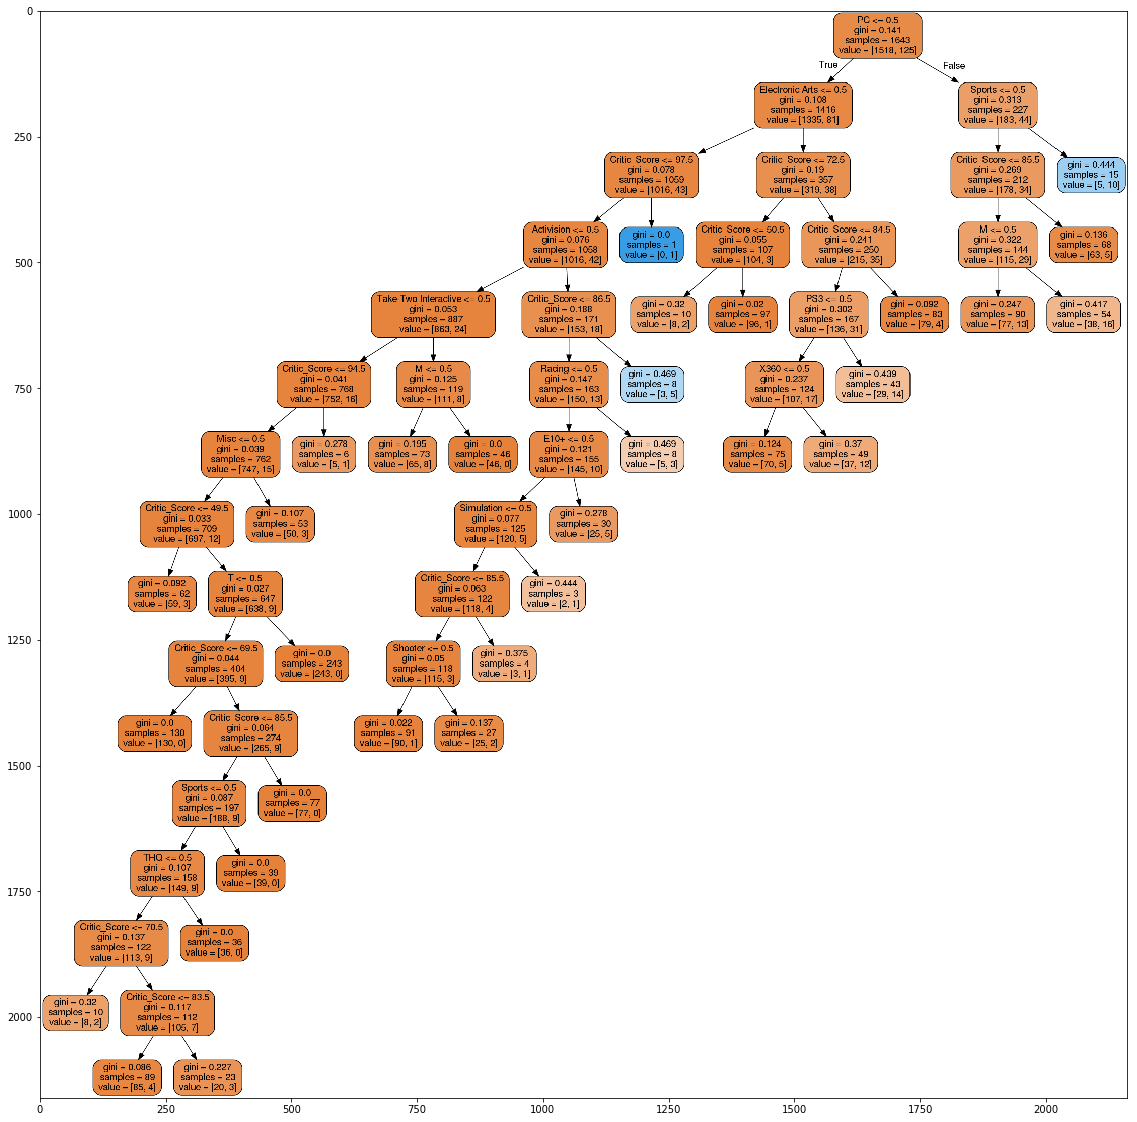

In [12]:
show_tree(dt12, features, 'arbol_normal.png')

Árbol Oversampled:

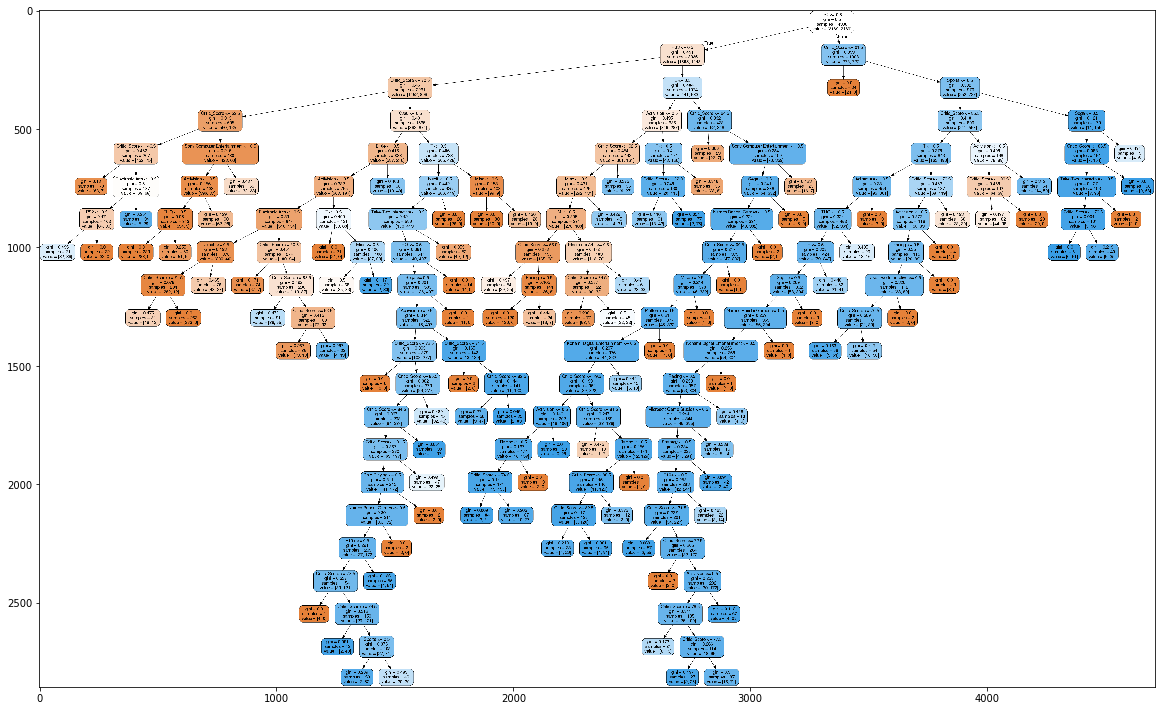

In [13]:
show_tree(dt13, features, 'arbol_oversampled.png')

Árbol Subsampled:

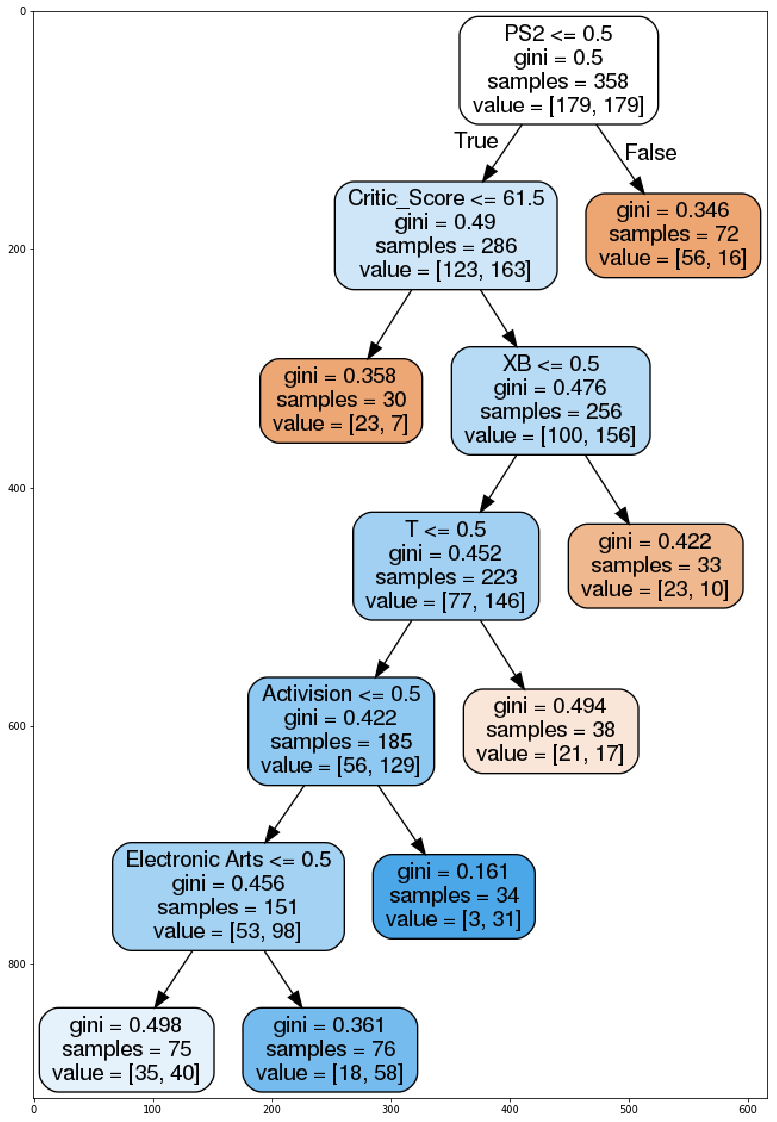

In [14]:
show_tree(dt14, features, 'arbol_subsampled.png')

Árbol con Oversampling y Subsampling:

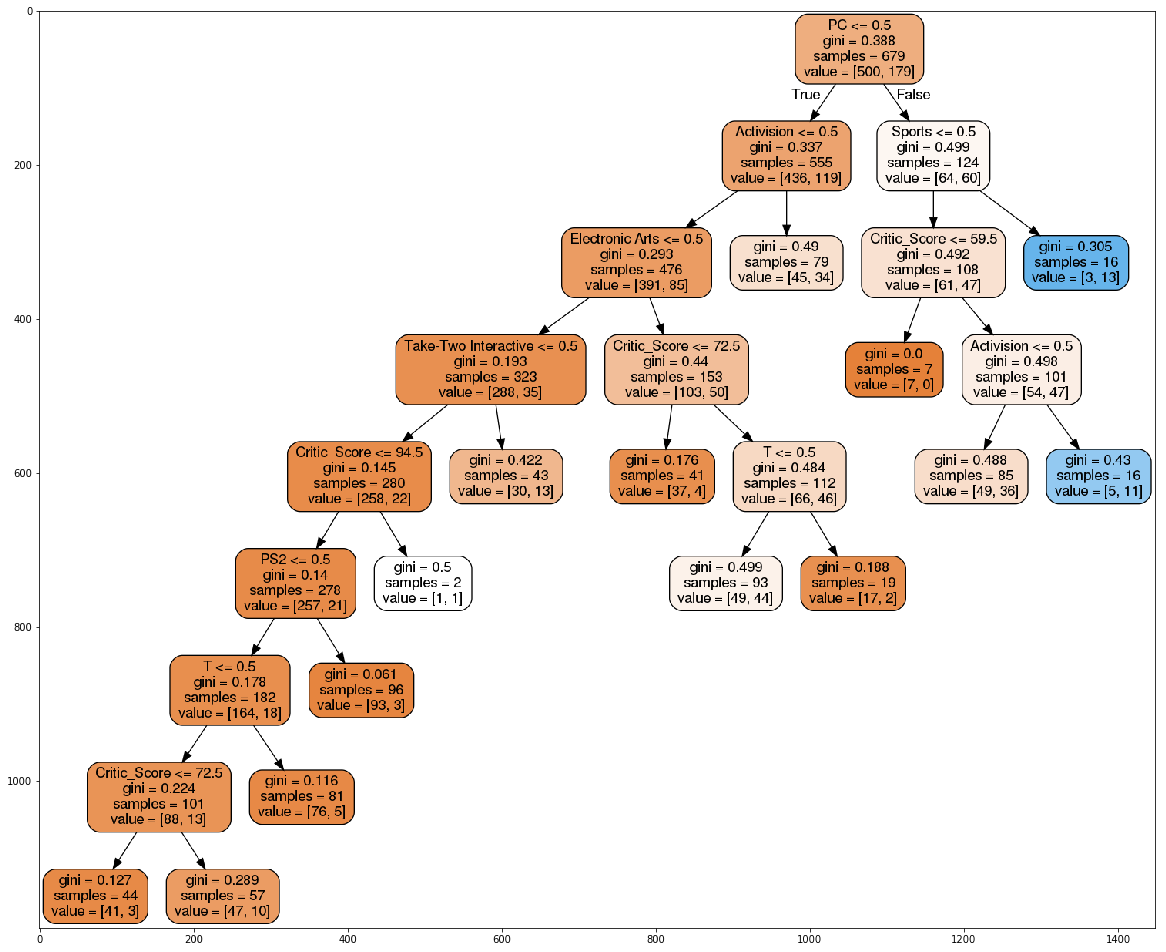

In [15]:
show_tree(dt15, features, 'arbol_master.png')

# 6 - Random Forest
Se aplica Random Forest para obtener los atributos que tienen mayor importancia en los árboles de decisión.

In [16]:

clf6 = RandomForestClassifier(n_estimators= 1000,max_depth=100, random_state=0)
train, test= train_test_split(new_data,test_size=.30, stratify=y)

        
X_train= train[features]
y_train=train["Is_Fiasco"]

X_test=test[features]
y_test=test["Is_Fiasco"]
clf6.fit(X_train, y_train)
import operator
mi_lista_de_tuplas = []
for i in range(33):
    tupla = (header[i],clf6.feature_importances_[i])
    mi_lista_de_tuplas.append(tupla)
mi_lista_de_tuplas.sort(key=operator.itemgetter(1), reverse=True)
for i in range(33):
    print(mi_lista_de_tuplas[i])

('Critic_Score', 0.4881052331762362)
('PC', 0.038234145323601906)
('Activision', 0.03687937937019606)
('Electronic Arts', 0.030406292502610396)
('Action', 0.027743644680361806)
('E', 0.026092514131681583)
('X360', 0.024475149263026973)
('T', 0.02336681895031325)
('PS3', 0.023065202128292356)
('Sports', 0.023011341533961085)
('PS2', 0.022771960457890913)
('E10+', 0.022545185637170385)
('Racing', 0.019299499356407537)
('Take-Two Interactive', 0.01928992887606864)
('XB', 0.01908453648420212)
('M', 0.018372532542254568)
('Shooter', 0.01583168451303431)
('Role-Playing', 0.013513433521144369)
('Misc', 0.012159577036976408)
('Simulation', 0.012049513948047987)
('Ubisoft', 0.010998468150267254)
('Sega', 0.010455495154634342)
('Microsoft Game Studios', 0.010352379763611365)
('Platform', 0.009536272107766088)
('Sony Computer Entertainment', 0.009153443959959855)
('Strategy', 0.008859152705269)
('THQ', 0.007426567694666734)
('Konami Digital Entertainment', 0.006306047219279858)
('Namco Bandai Gam